In [1]:
%load_ext autoreload
%autoreload 2
import numpy as np
import numpy.ma as ma
import matplotlib
import matplotlib.pyplot as plt
import matplotlib.cm as cm
import matplotlib.ticker as ticker
import matplotlib.dates as dates
from mpl_toolkits.axes_grid1 import ImageGrid,make_axes_locatable,host_subplot
from mpl_toolkits.basemap import Basemap
from datetime import datetime, timedelta
import sys
import os
import pyPIPS.utils as utils
import pyPIPS.thermolib as thermo
import pyPIPS.DSDlib as dsd
import pyPIPS.disdrometer_module as dis
import pyPIPS.plotmodule as PIPSplot
import pyPIPS.simulator as sim
import pyPIPS.io as pipsio
import pyPIPS.PIPS as pips
import pyPIPS.parsivel_params as pp
import pyPIPS.parsivel_qc as pqc
from pyCRMtools.modules import plotmodule as plotmod
from pyCRMtools.modules import utils as CRMutils
from pyCRMtools.pycaps import arps_read
from pyCRMtools.pycaps import pycaps_fields
from pyCRMtools.pycaps import calvars_radar as radar
import pandas as pd
import xarray as xr
import glob
import numpy.random as random
from scipy.stats import gamma, uniform
from scipy.special import gamma as gammafunc
from scipy import ndimage
from metpy.plots import StationPlot
from metpy.calc import get_wind_components
from metpy.cbook import get_test_data
from metpy.plots import StationPlot
from metpy.plots.wx_symbols import current_weather, sky_cover
from metpy.units import units
%matplotlib inline


## You are using the Python ARM Radar Toolkit (Py-ART), an open source
## library for working with weather radar data. Py-ART is partly
## supported by the U.S. Department of Energy as part of the Atmospheric
## Radiation Measurement (ARM) Climate Research Facility, an Office of
## Science user facility.
##
## If you use this software to prepare a publication, please cite:
##
##     JJ Helmus and SM Collis, JORS 2016, doi: 10.5334/jors.119



/Users/dawson29/miniconda3/envs/pyPIPS/lib/python3.7/site-packages/pyart/graph/cm.py:104: FutureWarning: elementwise comparison failed; returning scalar instead, but in the future will perform elementwise comparison
  if 'red' in spec:
/Users/dawson29/miniconda3/envs/pyPIPS/lib/python3.7/site-packages/pyart/graph/cm_colorblind.py:32: FutureWarning: elementwise comparison failed; returning scalar instead, but in the future will perform elementwise comparison
  if 'red' in spec:


In [2]:
# Define dictionaries, keyed by case date (i.e. '060509', '060709', '060909', '033116'), to store parameters related
# to NEXRAD radar data, disdrometer data, and model output, respectively

# Case we are looking at right now. Should only have to change this up here and then execute all the cells below
# to generate the appropriate analysis
casedate = '033116'

# Import the file containing the dictionaries needed to gather the radar, disdrometer, and model data.
sys.path.append('/Users/dawson29/Dropbox/Projects/VORTEXSE/vortexse_enkf_dsd_study/configs/2016_IOP3')

from PIPSsim_1km_dicts import *

In [3]:
# Read in the PIPS data for the first probe for testing
dis_dict = init_dis_dict[casedate]
dirname = dis_dict['dis_dir']
filename = dis_dict['disfilenames'][0]
filepath = os.path.join(dirname, filename)
print("Reading file: {}".format(filepath))
conv_df, parsivel_df, vd_matrix_da = pipsio.read_PIPS(filepath)

Reading file: /Users/dawson29/sshfs_mounts/depot/data/Projects/VORTEXSE/obsdata/2016/PIPS/processed/IOP3/PIPS_1A_IOP_3_D1.txt
No GPS time information in the file! Setting offset to zero!


In [4]:
print(vd_matrix_da)
#print(spectrum_da.loc['2016-03-31T22:30'])
diameter_bins = pp.parsivel_parameters['avg_diameter_bins_mm']
# print(diameter_bins)
fallspeed_bins = pp.parsivel_parameters['avg_fallspeed_bins_mps']
# print(fallspeed_bins)

empirical_fallspeed = pips.calc_empirical_fallspeed(diameter_bins)
# print(empirical_fallspeed)

fallspeed_spectrum1 = pips.calc_fallspeed_spectrum(diameter_bins, fallspeed_bins, use_measured_fallspeed=False)
#print(fallspeed_spectrum1)
fallspeed_spectrum2 = pips.calc_fallspeed_spectrum(diameter_bins, fallspeed_bins, use_measured_fallspeed=True)
#print(fallspeed_spectrum2)

<xarray.DataArray (time_10s: 380, fallspeed_bin: 32, diameter_bin: 32)>
array([[[0, 0, ..., 0, 0],
        [0, 0, ..., 0, 0],
        ...,
        [0, 0, ..., 0, 0],
        [0, 0, ..., 0, 0]],

       [[0, 0, ..., 0, 0],
        [0, 0, ..., 0, 0],
        ...,
        [0, 0, ..., 0, 0],
        [0, 0, ..., 0, 0]],

       ...,

       [[0, 0, ..., 0, 0],
        [0, 0, ..., 0, 0],
        ...,
        [0, 0, ..., 0, 0],
        [0, 0, ..., 0, 0]],

       [[0, 0, ..., 0, 0],
        [0, 0, ..., 0, 0],
        ...,
        [0, 0, ..., 0, 0],
        [0, 0, ..., 0, 0]]])
Coordinates:
  * time_10s        (time_10s) datetime64[ns] 2016-03-31T22:11:50 ... 2016-03-31T23:15:00
    fallspeed       (fallspeed_bin) float64 0.05 0.15 0.25 ... 15.2 17.6 20.8
    diameter        (diameter_bin) float64 0.0625 0.1875 0.3125 ... 21.5 24.5
    min_diameter    (diameter_bin) float64 0.0 0.125 0.25 ... 18.0 20.0 23.0
    max_diameter    (diameter_bin) float64 0.125 0.25 0.375 ... 20.0 23.0 26.0
    min_

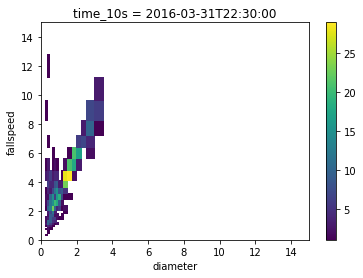

In [5]:
vd = vd_matrix_da.loc['2016-03-31T22:30:00']
vd['diameter'] = ('diameter_bin', diameter_bins)
vd['fallspeed'] = ('fallspeed_bin', fallspeed_bins)
vd.where(vd > 0.0).plot(x='diameter', y='fallspeed', xlim=[0., 15], ylim=[0., 15.])

Severe Wind contamination, masking entire PSD!
Severe Wind contamination, masking entire PSD!
Severe Wind contamination, masking entire PSD!
Severe Wind contamination, masking entire PSD!
380


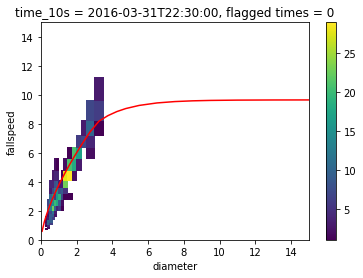

In [6]:
# Do some QC
vd_matrix_QC = pqc.strongwindQC(vd_matrix_da)
vd_matrix_QC = pqc.rainonlyQC(vd_matrix_QC)
vdQC = vd_matrix_QC.loc['2016-03-31T22:30:00']
vdQC['diameter'] = ('diameter_bin', diameter_bins)
vdQC['fallspeed'] = ('fallspeed_bin', fallspeed_bins)
vdQC.where(vdQC > 0.0).plot(x='diameter', y='fallspeed', xlim=[0., 15], ylim=[0., 15.])
plt.plot(diameter_bins, empirical_fallspeed, color='r')

/Users/dawson29/miniconda3/envs/pyPIPS/lib/python3.7/site-packages/xarray/core/computation.py:564: RuntimeWarning: divide by zero encountered in log10
  result_data = func(*input_data)


<xarray.DataArray (time_10s: 380, diameter_bin: 32)>
array([[0., 0., 0., ..., 0., 0., 0.],
       [0., 0., 0., ..., 0., 0., 0.],
       [0., 0., 0., ..., 0., 0., 0.],
       ...,
       [0., 0., 0., ..., 0., 0., 0.],
       [0., 0., 0., ..., 0., 0., 0.],
       [0., 0., 0., ..., 0., 0., 0.]])
Coordinates:
  * time_10s       (time_10s) datetime64[ns] 2016-03-31T22:11:50 ... 2016-03-31T23:15:00
    diameter       (diameter_bin) float64 0.0625 0.1875 0.3125 ... 21.5 24.5
    min_diameter   (diameter_bin) float64 0.0 0.125 0.25 ... 18.0 20.0 23.0
    max_diameter   (diameter_bin) float64 0.125 0.25 0.375 ... 20.0 23.0 26.0
    flagged times  (time_10s) int64 0 0 0 0 0 0 0 0 0 0 ... 0 0 0 0 0 0 0 0 0 0
Dimensions without coordinates: diameter_bin


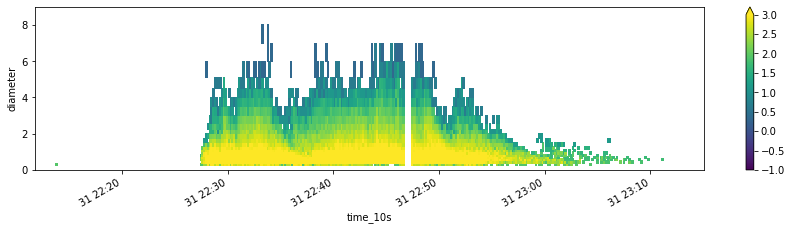

In [7]:
# Calculate ND
ND1 = pips.calc_ND(vd_matrix_QC.where(vd_matrix_QC > 0.0), fallspeed_spectrum1, 10.)
ND2 = pips.calc_ND(vd_matrix_QC.where(vd_matrix_QC > 0.0), fallspeed_spectrum2, 10.)
np.log10(ND1).T.plot(y='diameter', ylim=[0.0, 9.0], vmin=-1.0, vmax=3.0, aspect=5, size=3)
print(ND1)

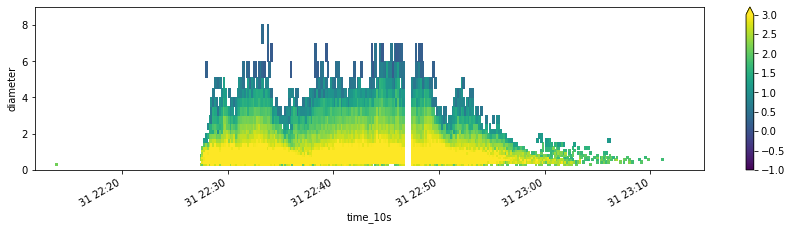

In [8]:
np.log10(ND2).T.plot(y='diameter', ylim=[0.0, 9.0], vmin=-1.0, vmax=3.0, aspect=5, size=3)

In [9]:
# Now resample the vd matrix across time to go from 10-s to 60-s intervals
resample_interval = pips.check_requested_resampling_interval(60., 10.)
vd_matrix_rs = pips.resample_vd_matrix(resample_interval, vd_matrix_QC)
print(vd_matrix_QC['time_10s'][:10])
print(vd_matrix_rs['time_10s'][:10])

Requested DSD interval: 60.0. Actual DSD interval: 60.0
<xarray.DataArray 'time_10s' (time_10s: 10)>
array(['2016-03-31T22:11:50.000000000', '2016-03-31T22:12:00.000000000',
       '2016-03-31T22:12:10.000000000', '2016-03-31T22:12:20.000000000',
       '2016-03-31T22:12:30.000000000', '2016-03-31T22:12:40.000000000',
       '2016-03-31T22:12:50.000000000', '2016-03-31T22:13:00.000000000',
       '2016-03-31T22:13:10.000000000', '2016-03-31T22:13:20.000000000'],
      dtype='datetime64[ns]')
Coordinates:
  * time_10s       (time_10s) datetime64[ns] 2016-03-31T22:11:50 ... 2016-03-31T22:13:20
    flagged times  (time_10s) int64 0 0 0 0 0 0 0 0 0 0
<xarray.DataArray 'time_10s' (time_10s: 10)>
array(['2016-03-31T22:11:50.000000000', '2016-03-31T22:12:50.000000000',
       '2016-03-31T22:13:50.000000000', '2016-03-31T22:14:50.000000000',
       '2016-03-31T22:15:50.000000000', '2016-03-31T22:16:50.000000000',
       '2016-03-31T22:17:50.000000000', '2016-03-31T22:18:50.000000000',
       '

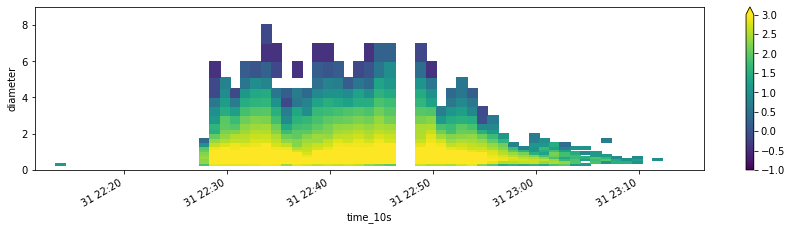

In [10]:
ND_resampled = pips.calc_ND(vd_matrix_rs.where(vd_matrix_rs > 0.0), fallspeed_spectrum1, 60.)
np.log10(ND_resampled).T.plot(y='diameter', ylim=[0.0, 9.0], vmin=-1.0, vmax=3.0, aspect=5, size=3)



In [11]:
# Add additional thermodynamic variables to conv_df
conv_df = pips.calc_thermo(conv_df)


Index(['GPS_alt', 'GPS_date', 'GPS_dir', 'GPS_lat', 'GPS_lon', 'GPS_magvar',
       'GPS_spd', 'GPS_status', 'GPS_time', 'RH', 'RH_derived', 'compass_dir',
       'dewpoint', 'fasttemp', 'pressure', 'slowtemp', 'voltage', 'winddiag',
       'winddirabs', 'winddirrel', 'windspd', 'pt', 'qv', 'rho'],
      dtype='object')


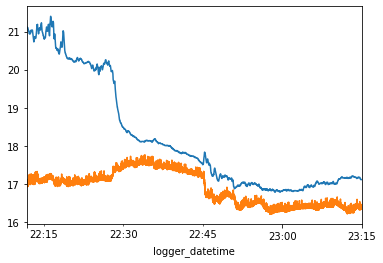

In [12]:
print(conv_df.columns)
conv_df['fasttemp'].plot()
conv_df['dewpoint'].plot()

In [13]:
# Resample conventional data to 60-s
datetime_range_onesec = conv_df.index.to_pydatetime()
sec_offset = pips.get_offset_seconds(datetime_range_onesec)
conv_rs_df = pips.resample_conv('PIPS', 60., sec_offset, conv_df)

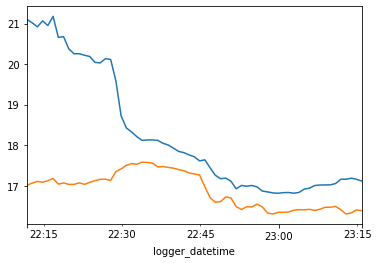

In [14]:
conv_rs_df['fasttemp'].plot()
conv_rs_df['dewpoint'].plot()

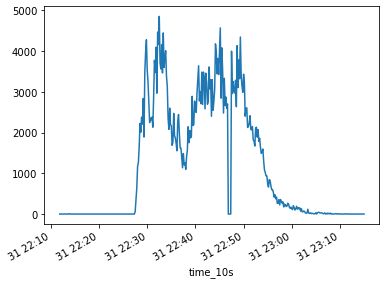

In [22]:
# Test calculation of moments
M0, M0_binned = dsd.calc_moment_bin(ND1, moment=0)
M0.plot()

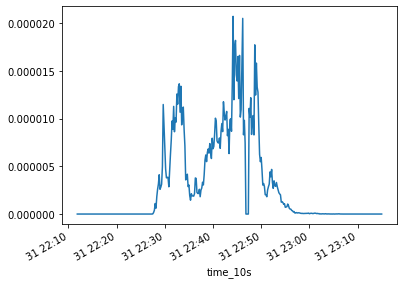

In [23]:
M3, M3_binned = dsd.calc_moment_bin(ND1, moment=3)
M3.plot()

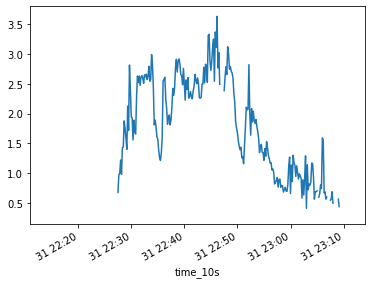

In [194]:
# Testing calculation of D0

D0 = dsd.calc_D0_bin(ND1) * 1000.
D0.plot()

<xarray.DataArray (diameter_bin: 32)>
array([         nan,          nan, 2.948665e-09, 3.667261e-08, 1.061218e-07,
       1.945775e-07, 2.051157e-07, 2.868942e-07, 2.584836e-07, 1.715617e-07,
       6.212696e-07, 8.115784e-07, 8.969734e-07, 7.647057e-07, 3.827815e-07,
       1.246991e-06, 8.211934e-07,          nan,          nan,          nan,
                nan,          nan,          nan,          nan,          nan,
                nan,          nan,          nan,          nan,          nan,
                nan,          nan])
Coordinates:
    diameter       (diameter_bin) float64 0.0625 0.1875 0.3125 ... 21.5 24.5
    min_diameter   (diameter_bin) float64 0.0 0.125 0.25 ... 18.0 20.0 23.0
    max_diameter   (diameter_bin) float64 0.125 0.25 0.375 ... 20.0 23.0 26.0
    time_10s       datetime64[ns] 2016-03-31T22:30:00
    flagged times  int64 0
Dimensions without coordinates: diameter_bin
[           nan            nan 2.94866450e-09 3.66726102e-08
 1.06121773e-07 1.94577541e-07 2.

/Users/dawson29/miniconda3/envs/pyPIPS/lib/python3.7/site-packages/numpy/lib/nanfunctions.py:1354: RuntimeWarning: All-NaN slice encountered
  overwrite_input, interpolation)


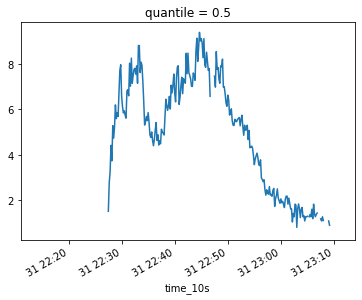

In [198]:
Dm = ND1['diameter'] / 1000.
M3, M3_binned = dsd.calc_moment_bin(ND1, moment=3)

M3_binned = M3_binned.where(M3_binned != 0.)
print(M3_binned.loc[dict(time_10s='2016-03-31T22:30:00')])
M3_arr = M3_binned.loc[dict(time_10s='2016-03-31T22:30:00')].values
print(M3_arr)
print()
M3_med = M3_binned.quantile(0.5, dim='diameter_bin', interpolation='linear')
print(M3_med.loc[dict(time_10s='2016-03-31T22:30:00')])
# D0 is the cube root of this median volume
D0 = M3_med**(1./3.) * 1000.
print(D0.loc[dict(time_10s='2016-03-31T22:30:00')])
D0.plot()

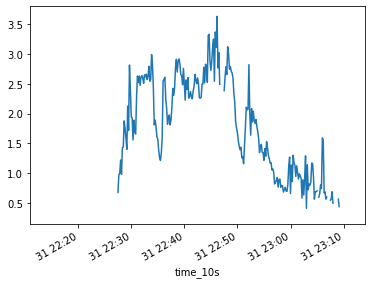

In [195]:
D0 = dsd.calc_D0_bin(ND1) * 1000.
D0.plot()

In [204]:
# Test interpolating from one index to another

da = xr.DataArray(np.sin(0.3 * np.arange(12).reshape(4, 3)),
                  [('time', np.arange(4)),
                   ('space', [0.1, 0.2, 0.3])])

other = xr.DataArray(np.sin(0.4 * np.arange(9).reshape(3, 3)),
                     [('time', [0.9, 1.9, 2.9]),
                      ('space', [0.1, 0.2, 0.3])])

In [205]:
print(da)
print(other)

<xarray.DataArray (time: 4, space: 3)>
array([[ 0.      ,  0.29552 ,  0.564642],
       [ 0.783327,  0.932039,  0.997495],
       [ 0.973848,  0.863209,  0.675463],
       [ 0.42738 ,  0.14112 , -0.157746]])
Coordinates:
  * time     (time) int64 0 1 2 3
  * space    (space) float64 0.1 0.2 0.3
<xarray.DataArray (time: 3, space: 3)>
array([[ 0.      ,  0.389418,  0.717356],
       [ 0.932039,  0.999574,  0.909297],
       [ 0.675463,  0.334988, -0.058374]])
Coordinates:
  * time     (time) float64 0.9 1.9 2.9
  * space    (space) float64 0.1 0.2 0.3


In [206]:
interpolated = da.interp_like(other)
interpolated


<xarray.DataArray (time: 3, space: 3)>
array([[ 0.704994,  0.868387,  0.95421 ],
       [ 0.954796,  0.870092,  0.707666],
       [ 0.482027,  0.213329, -0.074425]])
Coordinates:
  * time     (time) float64 0.9 1.9 2.9
  * space    (space) float64 0.1 0.2 0.3

In [207]:
x0 = 0
y0 = 0
x1 = 1
y1 = 0.783327

x = 0.9

y = y0 + (x - x0) * (y1 - y0) / (x1 - x0)
print(y)


0.7049943
